### CellStrat Hub Pack - Machine Learning

#### ML6 - IRIS Flower Classification with DT, RF and KNN

In [1]:
# Source Credit : *Python Machine Learning 2nd Edition* by [Sebastian Raschka]

# # Decision Trees classifier

In [2]:
# coding: utf-8

from sklearn import __version__ as sklearn_version
from distutils.version import LooseVersion
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

In [3]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import sklearn.tree as dtree

In [4]:
if LooseVersion(sklearn_version) < LooseVersion('0.18'):
    raise ValueError('Please use scikit-learn 0.18 or newer')

In [5]:
# *The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

# ### Overview

# - [Choosing a classification algorithm](#Choosing-a-classification-algorithm)
# - [First steps with scikit-learn](#First-steps-with-scikit-learn)
#     - [Training a perceptron via scikit-learn](#Training-a-perceptron-via-scikit-learn)
# - [Modeling class probabilities via logistic regression](#Modeling-class-probabilities-via-logistic-regression)
#     - [Logistic regression intuition and conditional probabilities](#Logistic-regression-intuition-and-conditional-probabilities)
#     - [Learning the weights of the logistic cost function](#Learning-the-weights-of-the-logistic-cost-function)
#     - [Training a logistic regression model with scikit-learn](#Training-a-logistic-regression-model-with-scikit-learn)
#     - [Tackling overfitting via regularization](#Tackling-overfitting-via-regularization)
# - [Maximum margin classification with support vector machines](#Maximum-margin-classification-with-support-vector-machines)
#     - [Maximum margin intuition](#Maximum-margin-intuition)
#     - [Dealing with the nonlinearly separable case using slack variables](#Dealing-with-the-nonlinearly-separable-case-using-slack-variables)
#     - [Alternative implementations in scikit-learn](#Alternative-implementations-in-scikit-learn)
# - [Solving nonlinear problems using a kernel SVM](#Solving-nonlinear-problems-using-a-kernel-SVM)
#     - [Using the kernel trick to find separating hyperplanes in higher dimensional space](#Using-the-kernel-trick-to-find-separating-hyperplanes-in-higher-dimensional-space)
# - [Decision tree learning](#Decision-tree-learning)
#     - [Maximizing information gain – getting the most bang for the buck](#Maximizing-information-gain-–-getting-the-most-bang-for-the-buck)
#     - [Building a decision tree](#Building-a-decision-tree)
#     - [Combining weak to strong learners via random forests](#Combining-weak-to-strong-learners-via-random-forests)
# - [K-nearest neighbors – a lazy learning algorithm](#K-nearest-neighbors-–-a-lazy-learning-algorithm)
# - [Summary](#Summary)

In [6]:
# # Choosing a classification algorithm

# ...

# # First steps with scikit-learn

# Loading the Iris dataset from scikit-learn. Here, the third column represents the petal length,
# and the fourth column the petal width of the flower samples. The classes are already converted
# to integer labels where 0=Iris-Setosa, 1=Iris-Versicolor, 2=Iris-Virginica.

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [7]:
# Splitting data into 70% training and 30% test data:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [8]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


In [9]:
# Standardizing the features:

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [10]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

In [11]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

In [12]:
# # Decision tree learning

# ## Maximizing information gain - getting the most bang for the buck
#For a more visual comparison of the three different impurity criteria, let's plot the impurity
#indices
# for the probability range [0, 1] for class 1.
# Note that we will also add in a scaled version of the entropy (entropy/2)
# to observe that the Gini index is an intermediate measure between entropy and the classification
#error.

def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

In [13]:
x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

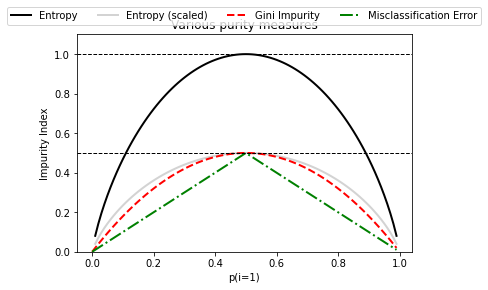

In [14]:
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini Impurity', 'Misclassification Error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
#plt.savefig('images/03_19.png', dpi=300, bbox_inches='tight')
plt.title("Various purity measures")
plt.show()

In [15]:
# ## Building a decision tree

tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=2, 
                              random_state=1)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=1)

In [16]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

<ipython-input-10-7c65ed7a3c58>:33: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


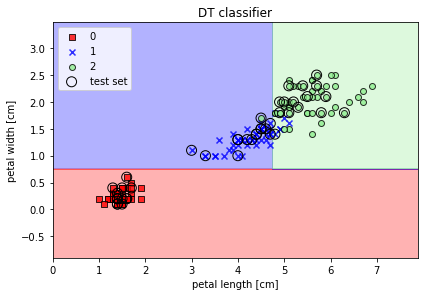

In [17]:
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_20.png', dpi=300)
plt.title("DT classifier")
plt.show()

[Text(133.92000000000002, 181.2, 'X[1] <= 0.75\ngini = 0.667\nsamples = 105\nvalue = [35, 35, 35]'),
 Text(66.96000000000001, 108.72, 'gini = 0.0\nsamples = 35\nvalue = [35, 0, 0]'),
 Text(200.88000000000002, 108.72, 'X[0] <= 4.75\ngini = 0.5\nsamples = 70\nvalue = [0, 35, 35]'),
 Text(133.92000000000002, 36.23999999999998, 'gini = 0.0\nsamples = 30\nvalue = [0, 30, 0]'),
 Text(267.84000000000003, 36.23999999999998, 'gini = 0.219\nsamples = 40\nvalue = [0, 5, 35]')]

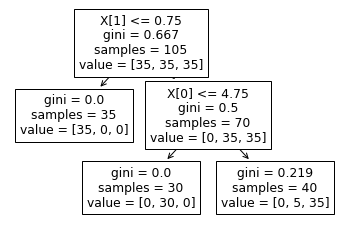

In [18]:
dtree.plot_tree(tree)

In [19]:
"""
dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=['Setosa', 
                                        'Versicolor',
                                        'Virginica'],
                           feature_names=['petal length', 
                                          'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png')
"""

"\ndot_data = export_graphviz(tree,\n                           filled=True, \n                           rounded=True,\n                           class_names=['Setosa', \n                                        'Versicolor',\n                                        'Virginica'],\n                           feature_names=['petal length', \n                                          'petal width'],\n                           out_file=None) \ngraph = graph_from_dot_data(dot_data) \ngraph.write_png('tree.png')\n"

In [20]:
# ## Combining weak to strong learners via random forests

forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=25, n_jobs=2, random_state=1)

<ipython-input-10-7c65ed7a3c58>:33: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


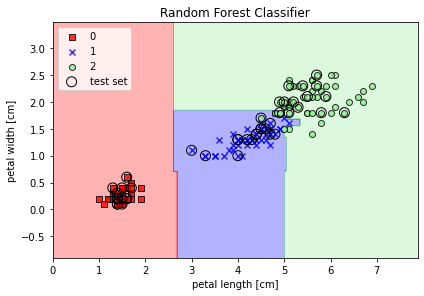

In [21]:
plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_22.png', dpi=300)
plt.title("Random Forest Classifier")
plt.show()

In [22]:
# # K-nearest neighbors - a lazy learning algorithm

knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
knn.fit(X_train_std, y_train)

KNeighborsClassifier()

<ipython-input-10-7c65ed7a3c58>:33: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


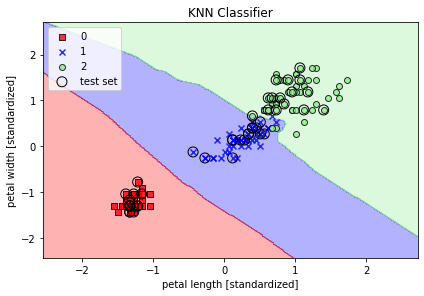

In [23]:
plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_24.png', dpi=300)
plt.title("KNN Classifier")
plt.show()